<a href="https://colab.research.google.com/github/CesarRiascos/assitant_ia/blob/main/yolo_drone_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
aruchomu_data_for_yolo_v3_kernel_path = kagglehub.dataset_download('aruchomu/data-for-yolo-v3-kernel')
valentynsichkar_yolo_coco_data_path = kagglehub.dataset_download('valentynsichkar/yolo-coco-data')
dasmehdixtr_drone_dataset_uav_path = kagglehub.dataset_download('dasmehdixtr/drone-dataset-uav')
andrewmvd_medical_mnist_path = kagglehub.dataset_download('andrewmvd/medical-mnist')
alincijov_self_driving_cars_path = kagglehub.dataset_download('alincijov/self-driving-cars')
sharansmenon_animals141_path = kagglehub.dataset_download('sharansmenon/animals141')
muki2003_yolo_drone_detection_dataset_path = kagglehub.dataset_download('muki2003/yolo-drone-detection-dataset')
cybersimar08_drone_detection_path = kagglehub.dataset_download('cybersimar08/drone-detection')

print('Data source import complete.')


100%|██████████| 267M/267M [00:02<00:00, 129MB/s]

Extracting files...


100%|██████████| 220M/220M [00:01<00:00, 148MB/s]

Extracting files...


100%|██████████| 716M/716M [00:05<00:00, 141MB/s]

Extracting files...


100%|██████████| 84.8M/84.8M [00:00<00:00, 151MB/s]

Extracting files...


100%|██████████| 892M/892M [00:09<00:00, 100MB/s]

Extracting files...


100%|██████████| 60.5M/60.5M [00:00<00:00, 133MB/s]

Extracting files...


100%|██████████| 359M/359M [00:02<00:00, 150MB/s]

Extracting files...


Using Colab cache for faster access to the 'drone-detection' dataset.
Data source import complete.


In [1]:
!pip install  -U ultralytics albumentations==1.4.3 scipy==1.11.4 numpy==1.26.4


# <p style='font-family: Signika+Negative; background-color:#E1BEE7; font-weight:bold; color:#6A1B9A; border:3px solid #6A1B9A; border-radius:10px; box-shadow:0px 3px 10px rgba(0,0,0,0.2); padding:10px; text-align:center;'>✨ Settings ✨</p>


In [2]:
from ultralytics import YOLO
import os
import shutil
import random
import yaml
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches
import pandas as pd
import numpy as np

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# <p style='font-family: Signika+Negative; background-color:#E1BEE7; font-weight:bold; color:#6A1B9A; border:3px solid #6A1B9A; border-radius:10px; box-shadow:0px 3px 10px rgba(0,0,0,0.2); padding:10px; text-align:center;'>✨ Data preprocessing and visualization ✨</p>


In [12]:
import os
import random
import shutil
import kagglehub

# The dataset path is defined in the first cell. If not defined, we download it here.
try:
    path_var = dasmehdixtr_drone_dataset_uav_path
except NameError:
    path_var = kagglehub.dataset_download('dasmehdixtr/drone-dataset-uav')

base_dir = os.path.join(path_var, "drone_dataset_yolo/dataset_txt")

# Ensure the path exists
if not os.path.exists(base_dir):
    # Search for the directory if the structure is different
    for root, dirs, files in os.walk(path_var):
        if "dataset_txt" in root:
            base_dir = root
            break

images = [f for f in os.listdir(base_dir) if f.endswith(".jpg")]

train_split, val_split, test_split = 0.75, 0.15, 0.1

random.shuffle(images)
n = len(images)
train_imgs = images[:int(n*train_split)]
val_imgs = images[int(n*train_split):int(n*(train_split+val_split))]
test_imgs = images[int(n*(train_split+val_split)):]

def copy_pairs(img_list, dest_folder):
    for img in img_list:
        label = img.replace(".jpg", ".txt")
        img_dest = f"dataset/images/{dest_folder}"
        label_dest = f"dataset/labels/{dest_folder}"

        shutil.copy(os.path.join(base_dir, img), os.path.join(img_dest, img))
        if os.path.exists(os.path.join(base_dir, label)):
            shutil.copy(os.path.join(base_dir, label), os.path.join(label_dest, label))

# Create directories
for split in ["train", "val", "test"]:
    os.makedirs(f"dataset/images/{split}", exist_ok=True)
    os.makedirs(f"dataset/labels/{split}", exist_ok=True)

copy_pairs(train_imgs, "train")
copy_pairs(val_imgs, "val")
copy_pairs(test_imgs, "test")

print("Everything is going as expected!")

Using Colab cache for faster access to the 'drone-dataset-uav' dataset.
Everything is going as expected!


In [6]:
for root, dirs, files in os.walk("dataset"):
    print(root, len(files), "files")


In [7]:
import yaml

data = {
    'train': 'dataset/images/train',
    'val': 'dataset/images/val',
    'test': 'dataset/images/test',
    'nc': 1,
    'names': ['drone']
}

with open('data.yaml', 'w') as f:
    yaml.dump(data, f, sort_keys=False)

print("File data.yaml created!")

File data.yaml created!


In [13]:
img_dir = "dataset/images/train"
label_dir = "dataset/labels/train"

augmentor = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomGamma(p=0.3),
    A.Rotate(limit=15, p=0.4, border_mode=cv2.BORDER_REFLECT_101),
    A.Blur(blur_limit=3, p=0.2),
    A.HueSaturationValue(p=0.3)
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

num_aug = 1

def clip_boxes(bboxes):
    clipped = []
    for box in bboxes:
        x, y, w, h = [max(0, min(1, v)) for v in box]
        clipped.append([x, y, w, h])
    return clipped

for img_name in os.listdir(img_dir):
    if not img_name.endswith(".jpg"):
        continue

    img_path = os.path.join(img_dir, img_name)
    label_path = os.path.join(label_dir, img_name.replace(".jpg", ".txt"))

    image = cv2.imread(img_path)
    if image is None or not os.path.exists(label_path):
        continue

    with open(label_path) as f:
        boxes, classes = [], []
        for line in f.readlines():
            vals = line.strip().split()
            if len(vals) != 5:
                continue
            cls, x, y, bw, bh = map(float, vals)
            boxes.append([x, y, bw, bh])
            classes.append(int(cls))

    for i in range(num_aug):
        try:
            augmented = augmentor(image=image, bboxes=boxes, class_labels=classes)
        except ValueError:
            continue

        aug_img = augmented["image"]
        aug_boxes = clip_boxes(augmented["bboxes"])
        aug_classes = augmented["class_labels"]

        new_name = img_name.replace(".jpg", f"_aug{i}.jpg")
        cv2.imwrite(os.path.join(img_dir, new_name), aug_img)

        with open(os.path.join(label_dir, new_name.replace(".jpg", ".txt")), "w") as f:
            for cls, (x, y, bw, bh) in zip(aug_classes, aug_boxes):
                f.write(f"{cls} {x:.6f} {y:.6f} {bw:.6f} {bh:.6f}\n")

print("✅ Augmentation completed successfully!")

✅ Augmentation completed successfully!


# <p style='font-family: Signika+Negative; background-color:#E1BEE7; font-weight:bold; color:#6A1B9A; border:3px solid #6A1B9A; border-radius:10px; box-shadow:0px 3px 10px rgba(0,0,0,0.2); padding:10px; text-align:center;'>✨ Eda✨</p>


In [14]:
splits = ["train", "val", "test"]
for split in splits:
    n_imgs = len([f for f in os.listdir(f"dataset/images/{split}") if f.endswith(".jpg")])
    n_labels = len([f for f in os.listdir(f"dataset/labels/{split}") if f.endswith(".txt")])
    print(f"{split}: {n_imgs} immagini, {n_labels} label")


train: 2031 immagini, 2031 label
val: 204 immagini, 204 label
test: 136 immagini, 136 label


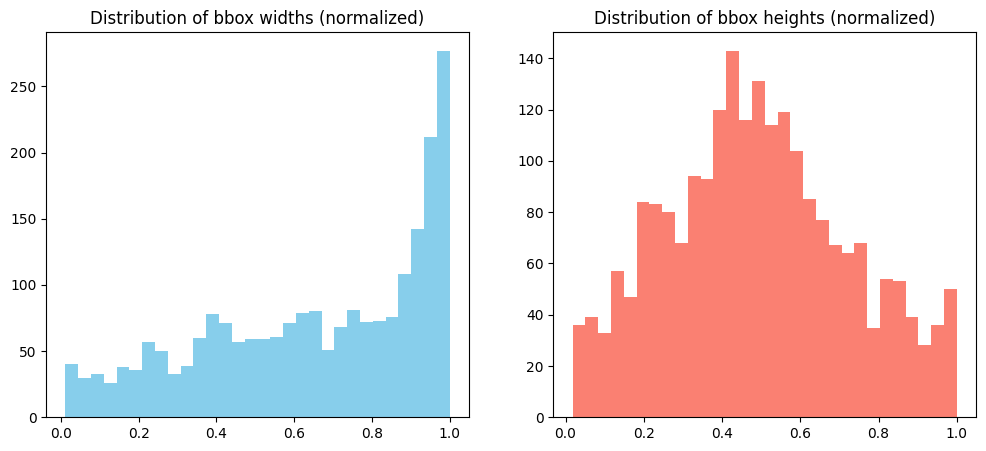

In [15]:
widths, heights = [], []

for label_file in os.listdir("dataset/labels/train"):
    if not label_file.endswith(".txt"):
        continue
    with open(os.path.join("dataset/labels/train", label_file)) as f:
        for line in f:
            cls, x, y, w, h = map(float, line.strip().split())
            widths.append(w)
            heights.append(h)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(widths, bins=30, color='skyblue')
plt.title("Distribution of bbox widths (normalized)")

plt.subplot(1,2,2)
plt.hist(heights, bins=30, color='salmon')
plt.title("Distribution of bbox heights (normalized)")

plt.show()


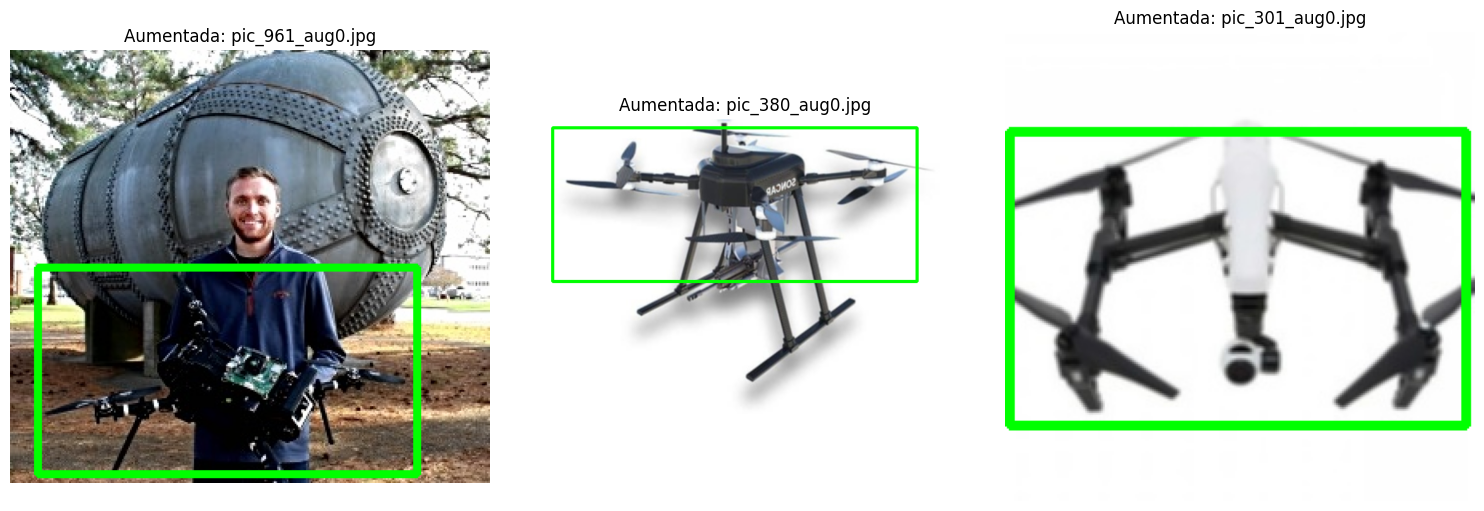

In [16]:
import os
import random
import cv2
import matplotlib.pyplot as plt

def show_augmented_examples(num_examples=3):
    img_dir = 'dataset/images/train'
    label_dir = 'dataset/labels/train'

    # Filtrar solo archivos que contienen '_aug'
    aug_files = [f for f in os.listdir(img_dir) if '_aug' in f and f.endswith('.jpg')]

    if not aug_files:
        print("No se encontraron imágenes aumentadas. Asegúrate de haber ejecutado la celda de aumentos.")
        return

    selected_files = random.sample(aug_files, min(num_examples, len(aug_files)))

    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(selected_files):
        img_path = os.path.join(img_dir, img_name)
        label_path = os.path.join(label_dir, img_name.replace('.jpg', '.txt'))

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h_img, w_img, _ = img.shape

        # Leer y dibujar bboxes
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    cls, x, y, w, h = map(float, line.split())
                    x1 = int((x - w/2) * w_img)
                    y1 = int((y - h/2) * h_img)
                    x2 = int((x + w/2) * w_img)
                    y2 = int((y + h/2) * h_img)
                    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 3)

        plt.subplot(1, num_examples, i + 1)
        plt.imshow(img)
        plt.title(f"Aumentada: {img_name}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_augmented_examples()

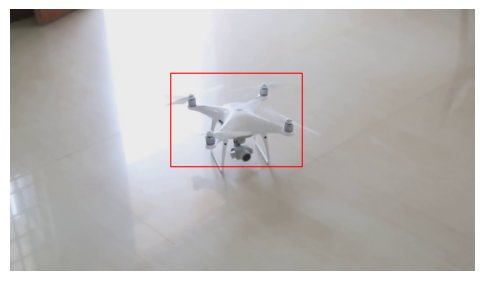

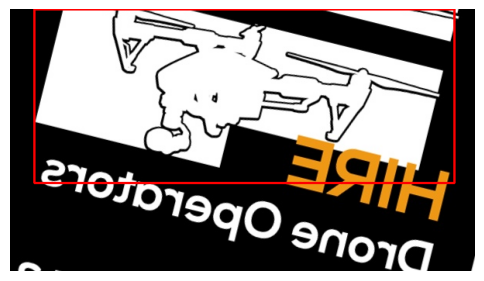

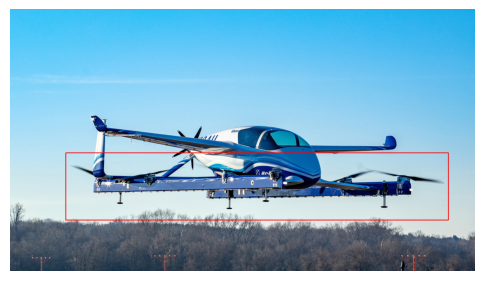

In [17]:
def show_image_with_bbox(split="train"):
    img_file = random.choice(os.listdir(f"dataset/images/{split}"))
    if not img_file.endswith(".jpg"):
        return
    img_path = f"dataset/images/{split}/{img_file}"
    label_path = f"dataset/labels/{split}/{img_file.replace('.jpg','.txt')}"

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    with open(label_path) as f:
        for line in f:
            cls, x, y, w, h = map(float, line.strip().split())
            h_img, w_img, _ = img.shape
            x1 = int((x - w/2) * w_img)
            y1 = int((y - h/2) * h_img)
            x2 = int((x + w/2) * w_img)
            y2 = int((y + h/2) * h_img)
            cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)

    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

show_image_with_bbox("train")
show_image_with_bbox("train")
show_image_with_bbox("train")

# <p style='font-family: Signika+Negative; background-color:#E1BEE7; font-weight:bold; color:#6A1B9A; border:3px solid #6A1B9A; border-radius:10px; box-shadow:0px 3px 10px rgba(0,0,0,0.2); padding:10px; text-align:center;'>✨ Train the model ✨</p>


In [18]:
model = YOLO('yolov8l.pt')

model.train(
    data='data.yaml',
    epochs=70,
    batch=16,
    imgsz=512,
    augment=True,
    project='drone_detection',
    name='yolov8_drone',
    exist_ok=True,
    save=True,
    save_period=5,
    patience=8,
    optimizer='AdamW',
    lr0=0.0005,
    lrf=0.1,
    momentum=0.9,
    weight_decay=0.0005,
    warmup_epochs=3,
    warmup_momentum=0.8,
    warmup_bias_lr=0.1,
    cache='ram',
    device='cuda',
    workers=8,
    deterministic=True,
    val=True,
    plots=True,
    amp=True,
    multi_scale=False,
    close_mosaic=10
)


Ultralytics 8.4.9 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=ram, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=70, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.1, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8l.pt, momentum=0.9, mosaic=1.0, multi_scale=False, name=yolov8_drone, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=8, perspective=0.0, plots=True, pose

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7bfe497ae3c0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

El archivo F1_curve.png no se encontró en runs/detect/drone_detection/yolov8_drone


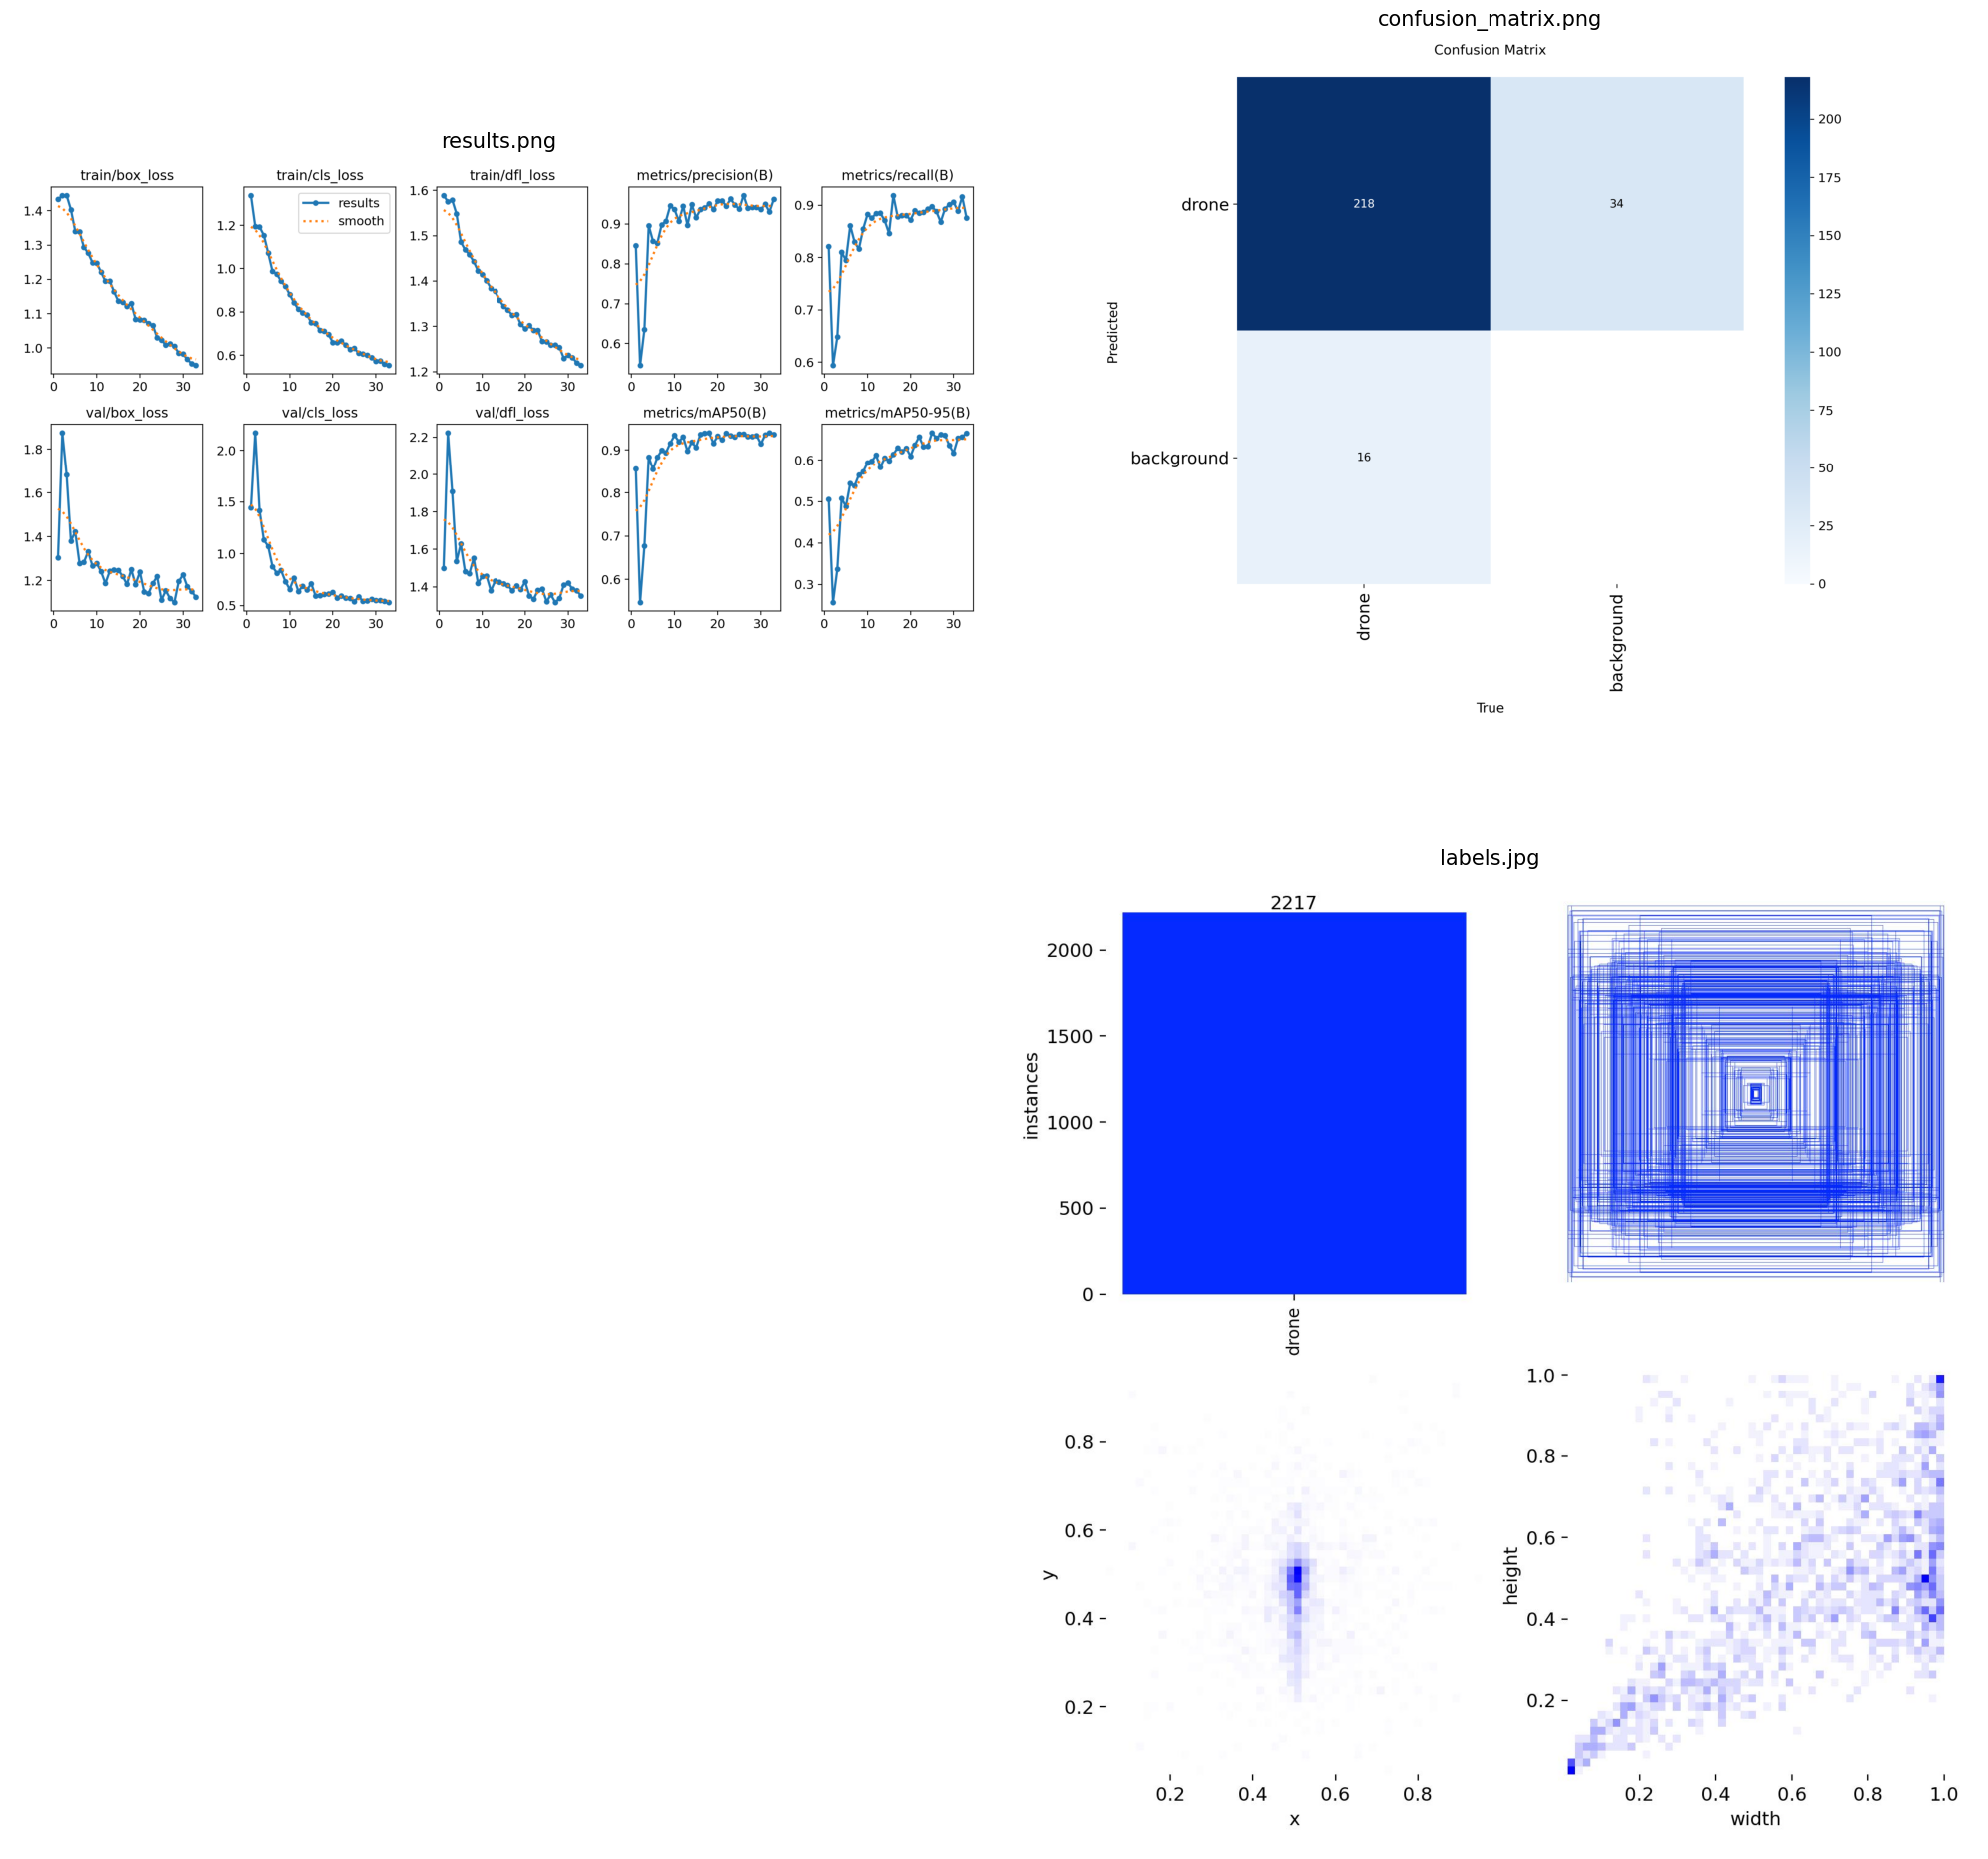

In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Definir la ruta donde se guardaron los resultados del entrenamiento
results_dir = 'runs/detect/drone_detection/yolov8_drone'

# Lista de archivos de imagen importantes que genera YOLO
plot_files = ['results.png', 'confusion_matrix.png', 'F1_curve.png', 'labels.jpg']

plt.figure(figsize=(20, 20))

for i, file_name in enumerate(plot_files):
    img_path = os.path.join(results_dir, file_name)
    if os.path.exists(img_path):
        img = mpimg.imread(img_path)
        plt.subplot(2, 2, i + 1)
        plt.imshow(img)
        plt.title(file_name, fontsize=15)
        plt.axis('off')
    else:
        print(f"El archivo {file_name} no se encontró en {results_dir}")

plt.tight_layout()
plt.show()

In [20]:
csv_path = "drone_detection/yolov8_drone/results.csv"

if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)

    table = df[['epoch', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
                'metrics/precision(B)', 'metrics/recall(B)',
                'metrics/mAP50(B)', 'metrics/mAP50-95(B)']]

    table = table.groupby('epoch', as_index=False).mean()
    display(table)
else:
    print("results.csv not found. Make sure training is finished and path is correct.")


results.csv not found. Make sure training is finished and path is correct.


# YOLOv8 Drone Detection

This project trains a **YOLOv8 model** (`yolov8`) to detect drones in images. The dataset is divided into **train, validation, and test splits**, and augmentation is applied both manually and during training.

## Training Configuration

- **Model:** `yolov8l.pt` (nano version, pre-trained)
- **Image size:** 512x512
- **Batch size:** 16
- **Epochs:** 70
- **Optimizer:** AdamW
- **Learning rate:** 0.0005
- **Early stopping patience:** 8 epochs
- **Mixed precision:** Enabled (`amp=True`)
- **Device:** GPU (`cuda`)
- **Checkpoint saving:** every 5 epochs
- **Mosaic:** Disabled in last 10 epochs

## Training Metrics

| Term       | Meaning                                                   | Notes / Tips                                         |
|-----------|-----------------------------------------------------------|-----------------------------------------------------|
| Epoch      | One full pass through the entire training dataset        | More epochs = more learning time; watch for overfitting |
| GPU_mem    | Amount of GPU memory used during training (GB)           | Helps assess if batch size or model is too large   |
| box_loss   | Loss related to the position and size of bounding boxes | Should decrease over time; lower is better         |
| cls_loss   | Classification loss for object classes                  | Lower values mean better classification accuracy   |
| dfl_loss   | Distribution Focal Loss for bounding box precision      | Should also decrease over training                 |
| Instances  | Number of objects detected in the batch                 | Indicates how many objects the model sees per batch |
| Size       | Input image size                                        | Balances between speed and accuracy                |

### Validation Metrics per Epoch

| Term      | Meaning                                                | Ideal Values / Notes                               |
|-----------|--------------------------------------------------------|---------------------------------------------------|
| Class     | Object class/category                                  | e.g., drone                                      |
| Images    | Number of images used in validation                   |                                                   |
| Instances | Total number of annotated objects in validation set   |                                                   |
| P         | Precision: fraction of correct positive detections    | Closer to 1 is better                             |
| R         | Recall: fraction of actual objects detected          | Closer to 1 is better                             |
| mAP50     | Mean Average Precision at IoU=0.5                     | Closer to 1 is better                             |
| mAP50-95  | Mean Average Precision averaged over IoU 0.5–0.95     | Higher is better; more robust evaluation         |

### Simple Explanation

- **Loss:** How much the model is currently "wrong" during training (lower is better)
- **Precision:** Of all objects the model predicted, how many were actually correct
- **Recall:** Of all the real objects present, how many did the model find
- **mAP (Mean Average Precision):** Combines precision and recall into a single performance metric, higher is better


# <p style='font-family: Signika+Negative; background-color:#E1BEE7; font-weight:bold; color:#6A1B9A; border:3px solid #6A1B9A; border-radius:10px; box-shadow:0px 3px 10px rgba(0,0,0,0.2); padding:10px; text-align:center;'>✨ Test the model ✨</p>

In [22]:
test_metrics = model.val(
    data='data.yaml', # Corregido: ruta local en lugar de Kaggle
    split='test',
    imgsz=512,
    batch=8,
    save=False,
    verbose=False
)

precision, recall, map50, map50_95 = test_metrics.mean_results()

print("\n-------------------------------------\n")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"mAP50: {map50:.3f}")
print(f"mAP50-95: {map50_95:.3f}")
print("\n-------------------------------------\n")

Ultralytics 8.4.9 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 46.7±45.8 MB/s, size: 305.8 KB)
val: Scanning /content/dataset/labels/test... 136 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 136/136 345.6it/s 0.4s
val: New cache created: /content/dataset/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.8it/s 4.5s
                   all        136        140      0.971      0.959      0.966      0.677
Speed: 1.6ms preprocess, 23.3ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to /content/runs/detect/val2

-------------------------------------

Precision: 0.971
Recall: 0.959
mAP50: 0.966
mAP50-95: 0.677

-------------------------------------



# <p style='font-family: Signika+Negative; background-color:#E1BEE7; font-weight:bold; color:#6A1B9A; border:3px solid #6A1B9A; border-radius:10px; box-shadow:0px 3px 10px rgba(0,0,0,0.2); padding:10px; text-align:center;'>✨ Visualize some examples ✨</p>



image 1/1 /content/dataset/images/test/pic_437.jpg: 288x512 1 drone, 48.9ms
Speed: 2.3ms preprocess, 48.9ms inference, 3.5ms postprocess per image at shape (1, 3, 288, 512)

image 1/1 /content/dataset/images/test/pic_719.jpg: 512x384 1 drone, 49.3ms
Speed: 2.2ms preprocess, 49.3ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 384)

image 1/1 /content/dataset/images/test/pic_787.jpg: 352x512 1 drone, 49.2ms
Speed: 1.9ms preprocess, 49.2ms inference, 2.1ms postprocess per image at shape (1, 3, 352, 512)


/tmp/ipython-input-2772674270.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(class_names))



image 1/1 /content/dataset/images/test/pic_014.jpg: 288x512 1 drone, 32.3ms
Speed: 2.4ms preprocess, 32.3ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 512)


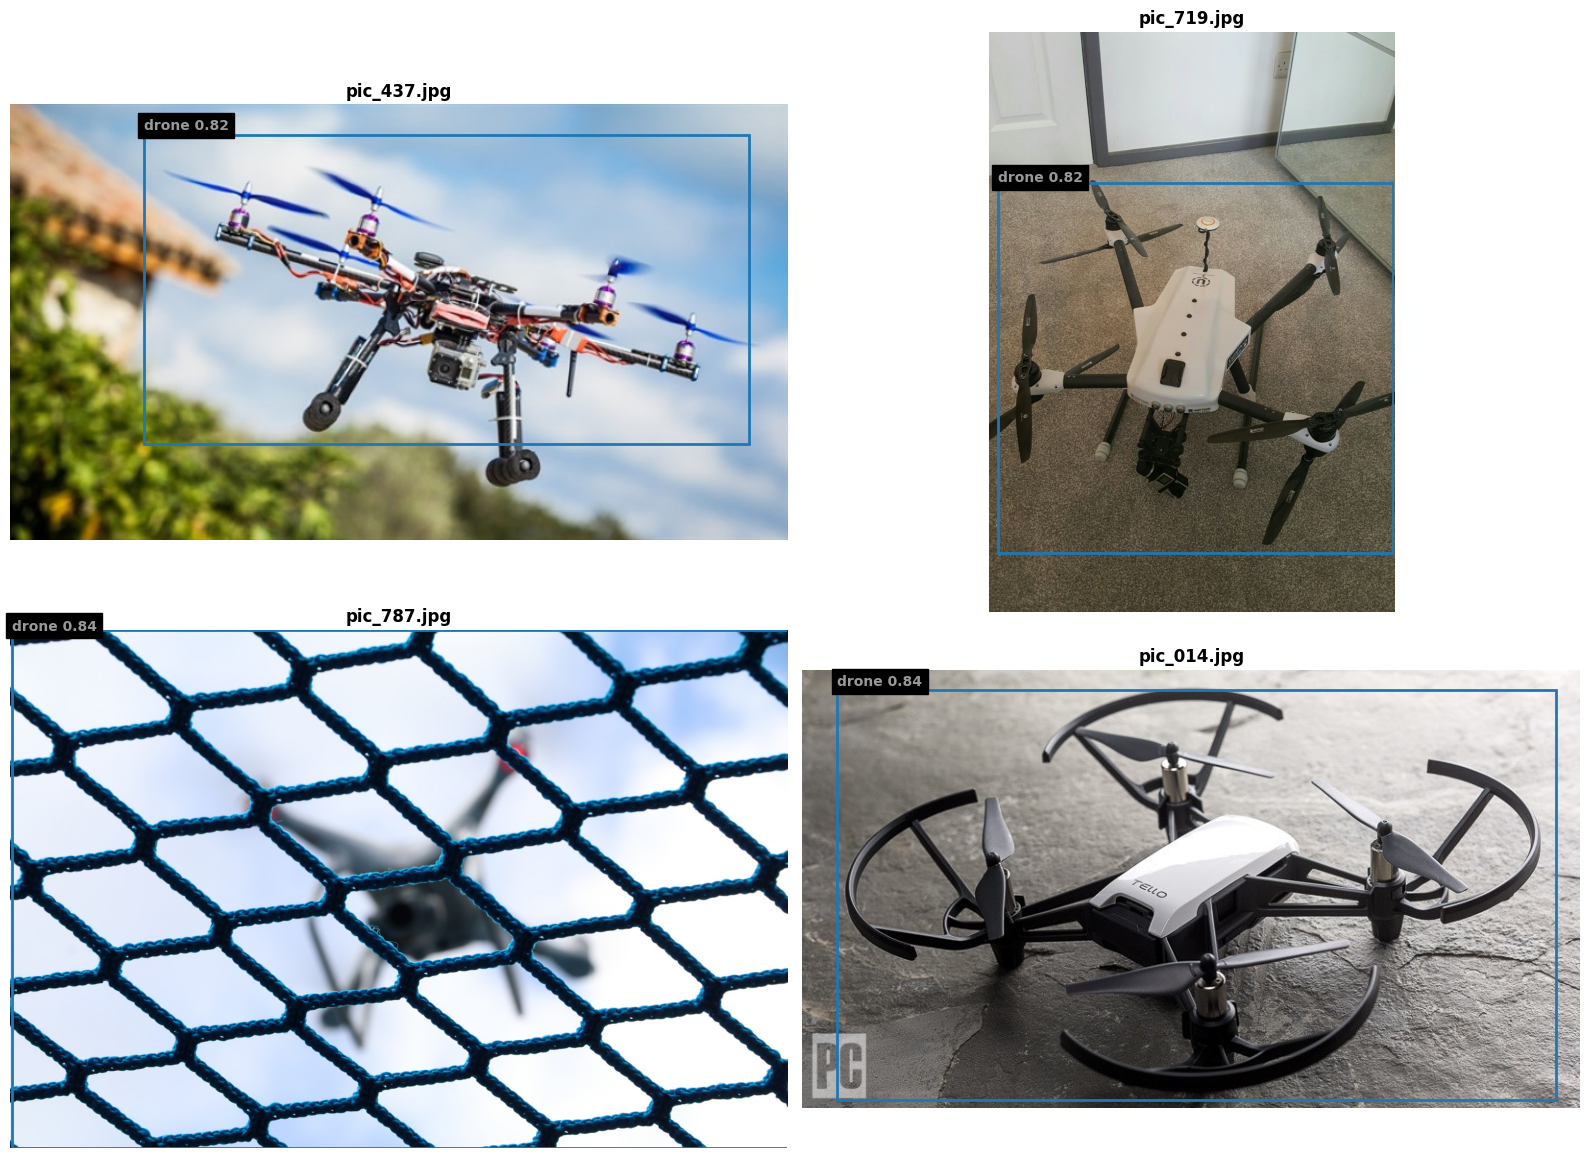

In [23]:
TEST_IMAGES_DIR = "dataset/images/test"

def show_inference(img_path, model, ax, class_names):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = model.predict(img_path)

    boxes = results[0].boxes.xyxy.cpu().numpy()
    scores = results[0].boxes.conf.cpu().numpy()
    classes = results[0].boxes.cls.cpu().numpy().astype(int)

    ax.imshow(img_rgb)
    ax.axis('off')
    ax.set_title(os.path.basename(img_path), fontsize=12, weight='bold')

    colors = plt.cm.get_cmap('tab20', len(class_names))

    for box, score, cl in zip(boxes, scores, classes):
        x1, y1, x2, y2 = box
        width, height = x2 - x1, y2 - y1
        rect = patches.Rectangle(
            (x1, y1), width, height,
            linewidth=2, edgecolor=colors(cl), facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(
            x1, max(0, y1 - 5),
            f'{class_names[cl]} {score:.2f}',
            color='white', fontsize=10, weight='bold',
            backgroundcolor='black', alpha=0.6
        )

test_imgs = os.listdir(TEST_IMAGES_DIR)
random_imgs = random.sample(test_imgs, min(4, len(test_imgs)))

fig, axs = plt.subplots(2, 2, figsize=(16, 12))
for img_path, ax in zip(random_imgs, axs.flatten()):
    full_path = os.path.join(TEST_IMAGES_DIR, img_path)
    show_inference(full_path, model, ax, data['names'])

plt.tight_layout()
plt.show()

In [24]:
model.save('final_drone_model.pt')

In [ ]:
import os

yaml_path = '/content/data.yaml'

if os.path.exists(yaml_path):
    print(f"✅ El archivo {yaml_path} existe.")
    print("\n--- Contenido de data.yaml ---")
    with open(yaml_path, 'r') as f:
        print(f.read())
else:
    print(f"❌ El archivo {yaml_path} NO fue encontrado en el directorio actual.")
    print("Directorio actual:", os.getcwd())
    print("Archivos presentes:", os.listdir('.'))